In [4]:
import tkinter as tk
from tkinter import filedialog
import os
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import cv2

In [5]:
# output_folder = "output_images"  # Nombre de la carpeta de salida
# os.makedirs(output_folder, exist_ok=True)

In [6]:
# OPEN DICOM images

root = tk.Tk()
root.withdraw()

PathAux = filedialog.askdirectory(title="DICOM Images")
#Dcm_ROI = pydicom.dcmread(file_name)
#Dcm_im_ROI = np.copy(Dcm_ROI.pixel_array)
    
Dcm_im_all = []
Dcm_order_all = []

for root,dirs,files in os.walk(PathAux):
    for i in files:
        if i.endswith(".dcm"):
            file_name=os.path.join(root,i)                  
            Dcm = pydicom.dcmread(file_name)
            Dcm_order = pydicom.valuerep.DSfloat(Dcm[0x0020,0x1041].value)
            Dcm_order_all.append(Dcm_order)
            Dcm_im = np.copy(Dcm.pixel_array)
            Dcm_im_all.append(Dcm_im)
        print('Name:',i)
        # plt.imshow(Dcm_im, cmap = plt.cm.bone)
        # plt.show()


# Sort the images based on the positions
sorted_indices = np.argsort(Dcm_order_all)
Dcm_im_all = [Dcm_im_all[i] for i in sorted_indices]
sorted_positions = [Dcm_order_all[i] for i in sorted_indices]

Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-1-14tx4qg.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-10-bok0d5.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-11-daxfmw.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-12-h1j4ff.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-13-285u3v.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-14-u7gf8x.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-15-1jfctku.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-16-1k30cxm.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-17-1lcc58o.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-2-1w6yaz9.dcm
Name: 1.2.826.0.1.3680043.9.6827.3440074202224637335148213065604128687-501-3-179hzq4.dcm
Name: 1.2.826.0.1.

In [7]:
# 3-labeled step
# Use rough mask and thresholded image
def three_labeled(rough_mask, thresholded_image):

    new_labelled_img = np.zeros_like(rough_mask)

    for j in range(rough_mask.shape[0]):  # Number of rows
        for i in range(rough_mask.shape[1]):  # Number of columns
            if rough_mask[j, i] == 1 and thresholded_image[j, i] == 1:
                new_labelled_img[j, i] = 2

            elif rough_mask[j, i] == 1 and thresholded_image[j, i] == 0:
                new_labelled_img[j, i] = 1

            elif rough_mask[j, i] == 0 and thresholded_image[j, i] == 0:
                new_labelled_img[j, i] = 0

            else:
                new_labelled_img[j, i] = 0

    return new_labelled_img

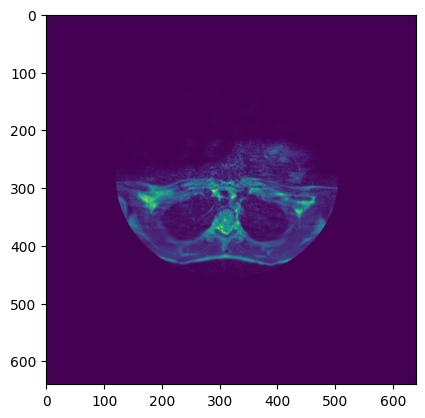

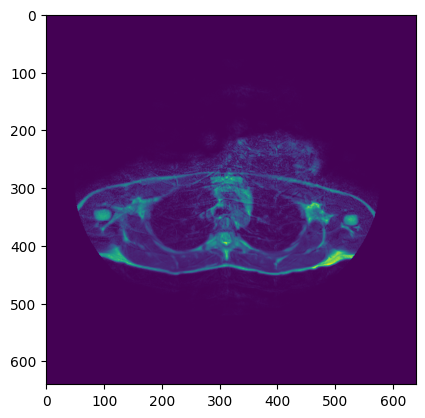

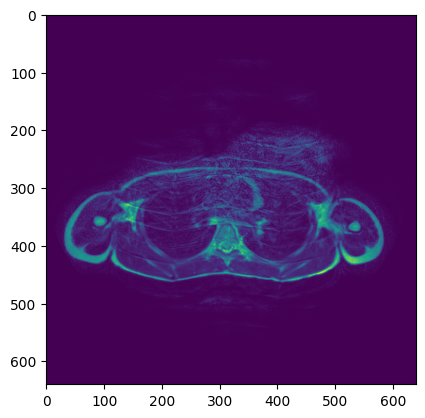

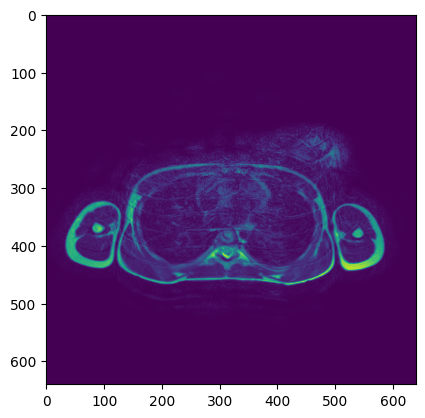

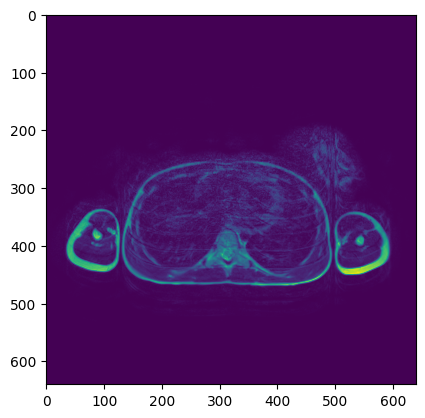

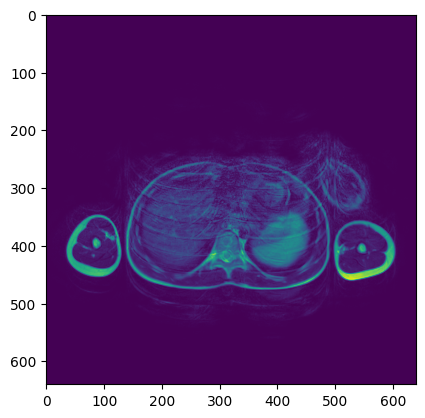

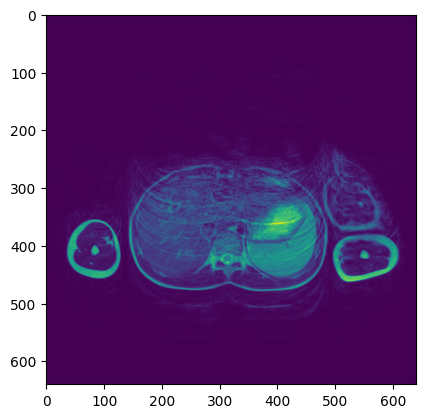

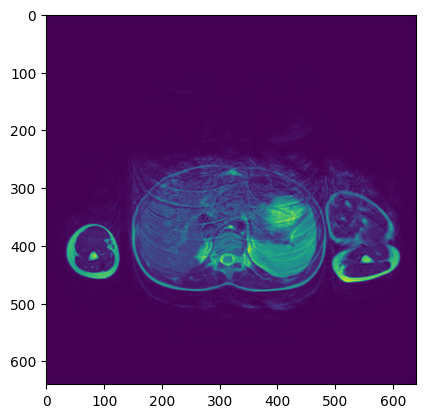

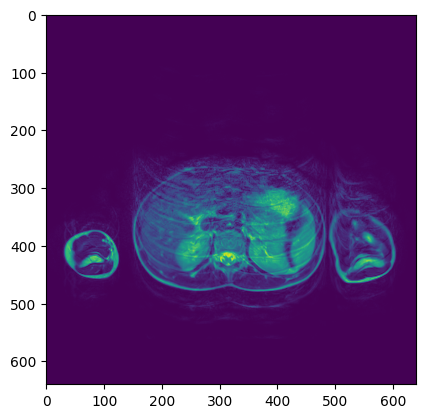

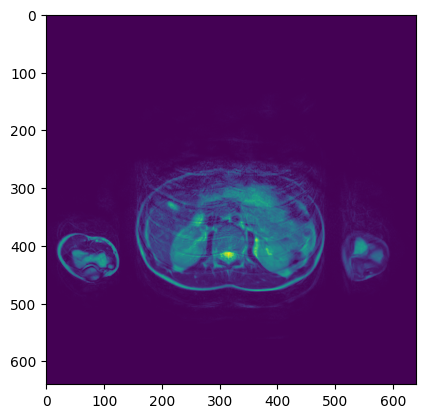

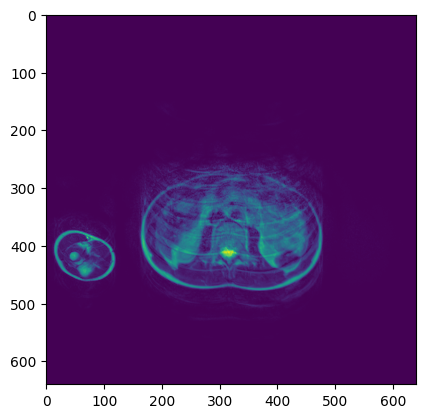

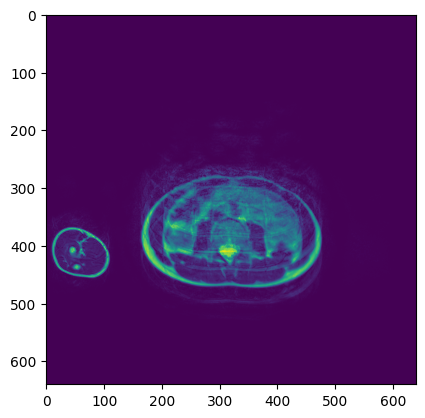

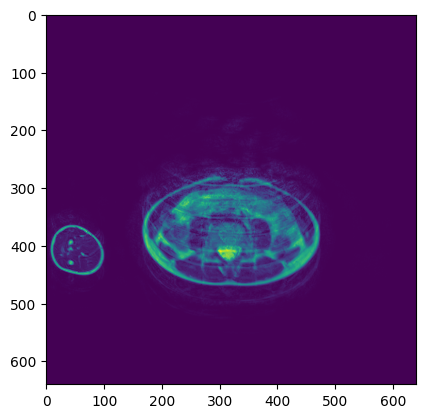

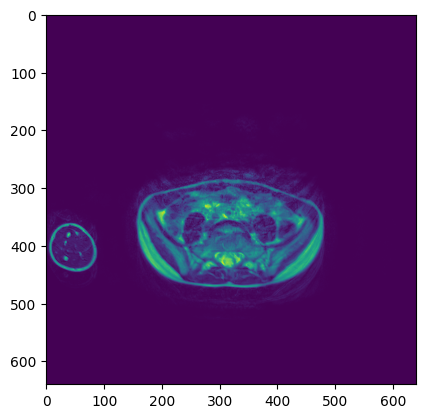

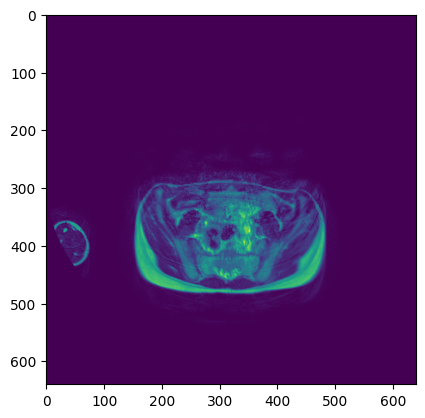

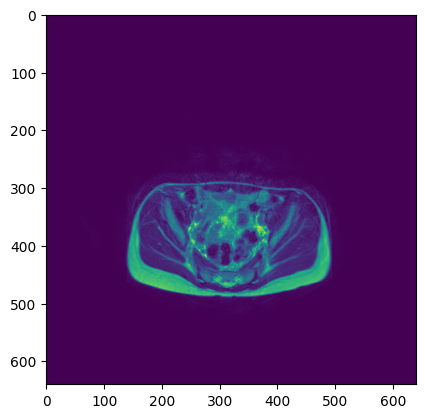

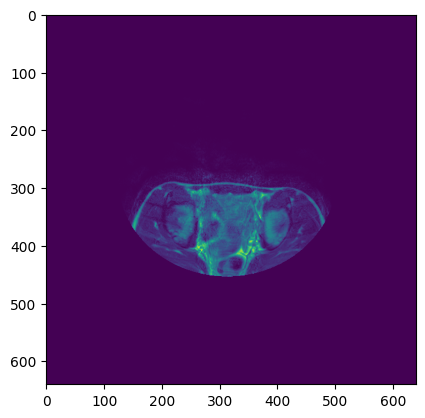

In [8]:


for slice in range(len(Dcm_im_all)):
    plt.imshow(Dcm_im_all[slice])
    plt.show()
        


In [9]:
for i in range(len(Dcm_im_all)):

    slice = Dcm_im_all[i]

    min_value = int(np.min(slice))
    max_value = int(np.max(slice))

    image = sitk.GetImageFromArray(slice)

    # Aplicar un estiramiento del histograma lineal
    mask = sitk.IntensityWindowing(image, min_value, 255, 0, 255)
    # Convert the SimpleITK image to a numpy array
    mask_array = sitk.GetArrayFromImage(mask)


    # OTSU THRESHOLDING?
    # Assuming 'image' is your SimpleITK image
    otsu_filter = sitk.OtsuThresholdImageFilter()
    # Optionally, specify the number of classes for Otsu thresholding (default is 1)
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(1)
    # Execute the filter
    binary_image = otsu_filter.Execute(mask)
    binary_image = mask >60

    imagefinal = sitk.GetArrayFromImage(binary_image)

    # plt.imshow(imagefinal)
    # plt.show()


    # Assuming 'binary_image' is your SimpleITK binary image
    binary_erode_filter = sitk.BinaryDilateImageFilter()

    # Optionally, specify the radius of the structuring element (default is 1)
    binary_erode_filter.SetKernelRadius(1)

    # Optionally, specify the number of iterations (default is 1)
    binary_erode_filter.SetNumberOfThreads(1)

    # Execute the filter
    eroded_binary_image = binary_erode_filter.Execute(binary_image)
    eroded_array = sitk.GetArrayFromImage(eroded_binary_image)

    non_zero_at_extremes = np.any(eroded_array[0, :] != 0) or \
                        np.any(eroded_array[-1, :] != 0) or \
                        np.any(eroded_array[:, 0] != 0) or \
                        np.any(eroded_array[:,-1]!=0)

    if non_zero_at_extremes:

        pad_size = [50, 50, 0] 
    # Especifica el valor que deseas asignar a los píxeles agregados
        pad_value = sitk.GetArrayFromImage(eroded_binary_image).max()
        pad_value = np.double(pad_value)

    # Aplica el relleno constante a la imagen
        padded_image = sitk.ConstantPad(eroded_binary_image, pad_size, pad_size, pad_value)

    else:
        padded_image = eroded_binary_image


    paddd = sitk.GetArrayFromImage(padded_image)

    fillhole_filter = sitk.BinaryFillholeImageFilter()

    # Aplicar el filtro a la máscara binaria
    mask_filled = fillhole_filter.Execute(padded_image)
    paddd1 = sitk.GetArrayFromImage(mask_filled)

    # plt.imshow(paddd1)
    # plt.show()


    three_labeled_image = three_labeled(paddd1, imagefinal)
    # plt.imshow(three_labeled_image, cmap=plt.cm.gray)
    # plt.show()
    three_labeled_image = (three_labeled_image == 1)

    # plt.imshow(three_labeled_image, cmap=plt.cm.gray)
    # plt.show()

    three_labeled_image_uint8 = three_labeled_image.astype(np.uint8)
    image4 = three_labeled_image_uint8

    # Convert the numpy array to a SimpleITK image
    image4 = sitk.GetImageFromArray(image4)

    # Perform connected component labeling
    component_image = sitk.ConnectedComponent(image4)

    # Relabel the connected components by object size
    sorted_component_image = sitk.RelabelComponent(component_image, sortByObjectSize=True)

    # Get the labels for the two largest components
    largest_component_label = 1
    second_largest_component_label = 2

    # Get the sizes of the largest and second largest components
    largest_component_size = np.sum(sitk.GetArrayViewFromImage(sorted_component_image == largest_component_label))
    second_largest_component_size = np.sum(sitk.GetArrayViewFromImage(sorted_component_image == second_largest_component_label))

    # Define a threshold for similarity
    threshold = 0.8  # Adjust as needed

    largest_component_binary_image = sorted_component_image == largest_component_label
    largest_component_array = sitk.GetArrayFromImage(largest_component_binary_image)

    # Compare the sizes of the two largest components
    if second_largest_component_size >= threshold * largest_component_size:
        # Extract the second largest component
        second_largest_component_binary_image = sorted_component_image == second_largest_component_label
        # Convert to numpy array for further processing
        second_largest_component_array = sitk.GetArrayFromImage(second_largest_component_binary_image)
        intersection = cv2.bitwise_or(largest_component_array, second_largest_component_array)

    else:
        # If the sizes are not similar, set the second largest component array to None or do other handling
        second_largest_component_array = None
        intersection = largest_component_array


    # plt.imshow(intersection, cmap='gray')
    # plt.show()


    filename = "image" + str(i) + ".png"
    # Specify the filename with the appropriate extension
    output_folder = r"C:\Users\elena\OneDrive - Universiteit Utrecht\MIX\Team Challenge\output_images"

    image_name = os.path.join(output_folder, filename)
  
    intersection= intersection*255
    # Save the image using cv2.imwrite()
    cv2.imwrite(image_name, intersection)

# image_name = os.path.join(output_folder, filename)
# print(image_name)
# 
# cv2.imwrite(r"C:\Users\elena\OneDrive - Universiteit Utrecht\MIX\Team Challenge\output_folder", intersection)